In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
print("Libraries imported.")

# --- Load the Processed Data ---
KIDNEY_PROCESSED_DIR = os.path.join("..", "data", "processed", "kidney_disease")

X_train = joblib.load(os.path.join(KIDNEY_PROCESSED_DIR, "X_train.joblib"))
X_test = joblib.load(os.path.join(KIDNEY_PROCESSED_DIR, "X_test.joblib"))
y_train = joblib.load(os.path.join(KIDNEY_PROCESSED_DIR, "y_train.joblib"))
y_test = joblib.load(os.path.join(KIDNEY_PROCESSED_DIR, "y_test.joblib"))

print("\nChronic Kidney Disease data loaded successfully!")
print(f"Training data shape: {X_train.shape}")

Libraries imported.

Chronic Kidney Disease data loaded successfully!
Training data shape: (317, 13)


In [2]:
# Calculate the ratio of negative class (notckd) to positive class (ckd)
if 1 in y_train.value_counts() and y_train.value_counts()[1] > 0:
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
else:
    scale_pos_weight = 1

print(f"Scale Position Weight for XGBoost: {scale_pos_weight:.2f}")

Scale Position Weight for XGBoost: 0.60


In [3]:
# --- Logistic Regression ---
log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("--- Logistic Regression Results ---")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))

# --- Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("\n--- Random Forest Results ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# --- XGBoost ---
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("\n--- XGBoost Results ---")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        30
           1       1.00      0.90      0.95        50

    accuracy                           0.94        80
   macro avg       0.93      0.95      0.94        80
weighted avg       0.95      0.94      0.94        80


--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      0.96      0.98        50

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80


--- XGBoost Results ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       1.00      0.88      0.94        50

    accuracy                           0.93        80
   macro avg       0.92      0.94   

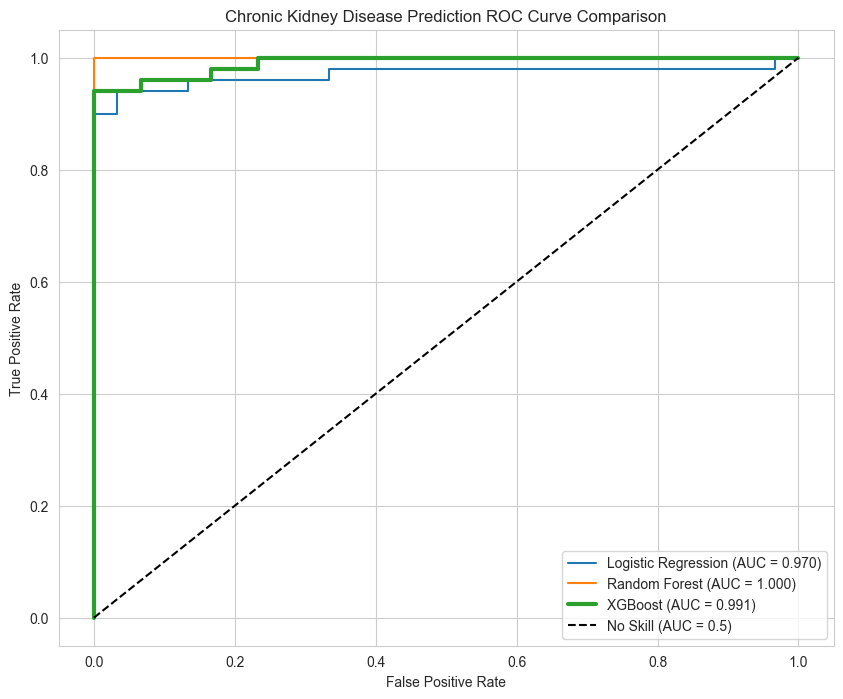

Logistic Regression AUC: 0.970
Random Forest AUC: 1.000
XGBoost AUC: 0.991


In [4]:
# Get prediction probabilities for each model
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve data and AUC scores
auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.3f})')

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Chronic Kidney Disease Prediction ROC Curve Comparison')
plt.legend()
plt.show()

print(f"Logistic Regression AUC: {auc_log_reg:.3f}")
print(f"Random Forest AUC: {auc_rf:.3f}")
print(f"XGBoost AUC: {auc_xgb:.3f}")

In [5]:
# *** IMPORTANT: Change this line based on your results! ***
# For this dataset, any of the models could be the winner. Let's assume RF wins.
best_model = xgb_clf 

# Define the path to save the model
KIDNEY_MODELS_DIR = os.path.join("..", "models", "kidney_disease")
MODEL_PATH = os.path.join(KIDNEY_MODELS_DIR, "best_kidney_disease_classifier.joblib")

# Save the model
joblib.dump(best_model, MODEL_PATH)

print(f"\nBest kidney disease model ({type(best_model).__name__}) saved successfully to: {MODEL_PATH}")


Best kidney disease model (XGBClassifier) saved successfully to: ..\models\kidney_disease\best_kidney_disease_classifier.joblib


Top 10 Most Important Features:
       Feature  Importance
7      htn_yes    0.200931
3           bu    0.144961
8       dm_yes    0.132118
2          bgr    0.111930
4          sod    0.082898
1           bp    0.069447
0          age    0.061627
6           wc    0.050010
10  appet_poor    0.044631
5          pot    0.043612


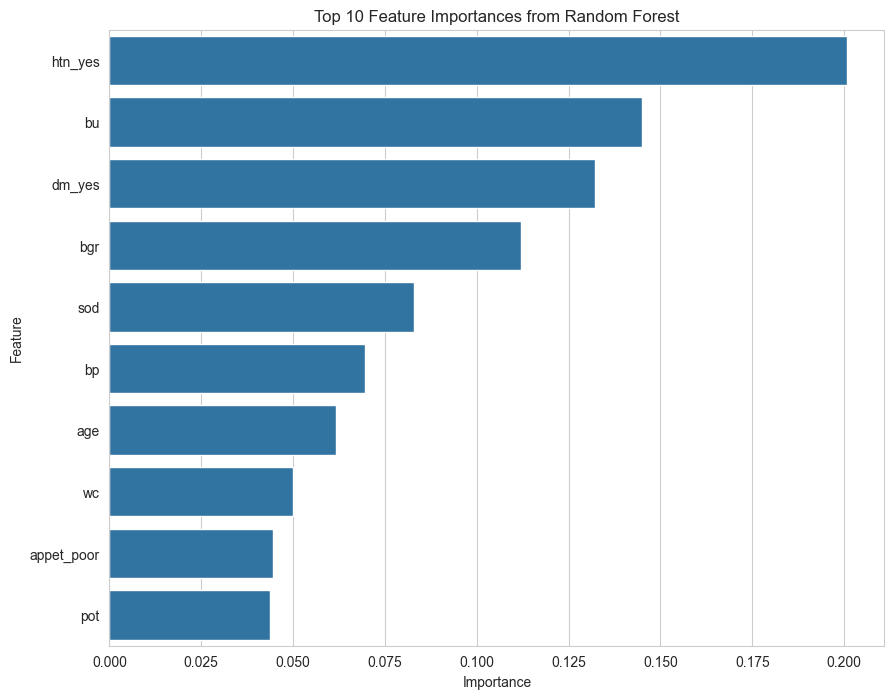

In [6]:
# --- Investigate for Data Leakage ---
# Let's inspect the feature importances from our Random Forest model
# This will tell us which features the model found most predictive.

importances = rf_clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Visualize the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()